In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from Project import Project

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from Scripts.TrainingUtils import Trainer, autoencoder_basic_training_routine, autoencoder_basic_validation_routine
from Scripts.data.TsinghuaDataset import TsinghuaDataset
from Scripts.data.Dataloader import Dataloader
from Models import Autoencoder

from torchsummary import summary

ngpu = 1; device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

***

In [4]:
BATCH_SIZE = 64
SIGNAL_LENGTH = 250
# NUM_SUBJECTS = 5 + 1
NUM_CLASSES = 5

# individuals = [*map(lambda k: str(k), [*range(1, NUM_SUBJECTS + 1)])]
# individuals.remove('5')

classes = list(range(1, NUM_CLASSES + 1))
dataset = TsinghuaDataset('benchmark', Project, SIGNAL_LENGTH, classes = classes)
dataloaders, _ = Dataloader(dataset, BATCH_SIZE)

__t-SNE Before Using an Autoencoder__

In [18]:
samples = np.asarray([sample[0].flatten().numpy() for sample in dataloaders['val'].dataset])
targets = np.asarray([sample[1] for sample in dataloaders['val'].dataset])

In [19]:
tsne = TSNE(n_components = 2, verbose = 1, perplexity = 40)
# pca = PCA(n_components =  3000)

In [ ]:
pca_result = pca.fit_transform(samples)
print(np.sum(pca.explained_variance_ratio_))

In [21]:
tsne_results = tsne.fit_transform(samples)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 6120 samples in 28.753s...
[t-SNE] Computed neighbors for 6120 samples in 1098.740s...
[t-SNE] Computed conditional probabilities for sample 1000 / 6120
[t-SNE] Computed conditional probabilities for sample 2000 / 6120
[t-SNE] Computed conditional probabilities for sample 3000 / 6120
[t-SNE] Computed conditional probabilities for sample 4000 / 6120
[t-SNE] Computed conditional probabilities for sample 5000 / 6120
[t-SNE] Computed conditional probabilities for sample 6000 / 6120
[t-SNE] Computed conditional probabilities for sample 6120 / 6120
[t-SNE] Mean sigma: 27.675310
[t-SNE] KL divergence after 250 iterations with early exaggeration: 87.395515
[t-SNE] KL divergence after 1000 iterations: 2.857360


In [22]:
df = pd.DataFrame()
df['one'] = tsne_results[:, 0]
df['two'] = tsne_results[:, 1]
df['y']   = targets

<AxesSubplot:xlabel='one', ylabel='two'>

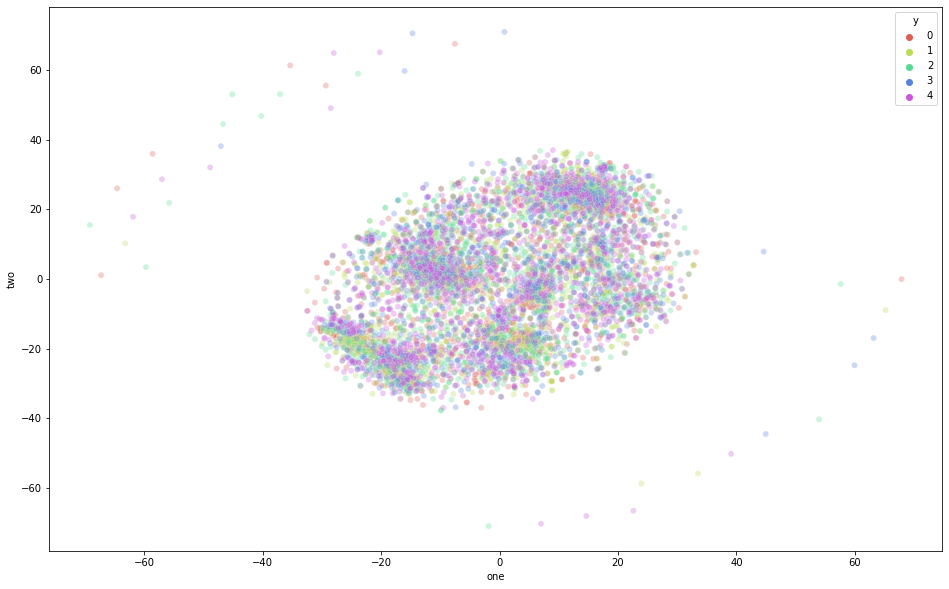

In [24]:
plt.figure(figsize = (16, 10))
sns.scatterplot(
    x = 'one', y = 'two',
    hue = 'y',
    palette = sns.color_palette('hls', NUM_CLASSES),
    data = df,
    legend = 'full',
    alpha = 0.3
)

***

In [5]:
from Models.Autoencoder import Autoencoder

In [54]:
model = Autoencoder(kernel_n = 11, stride = 2, n_feature_maps = 1).to(device)

In [55]:
summary(model, (1, 64, int(SIGNAL_LENGTH)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 1, 64, 125]              24
              ReLU-2           [-1, 1, 64, 125]               0
       BatchNorm2d-3           [-1, 1, 64, 125]               2
   ConvTranspose2d-4           [-1, 1, 64, 250]              24
Total params: 50
Trainable params: 50
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.06
Forward/backward pass size (MB): 0.31
Params size (MB): 0.00
Estimated Total Size (MB): 0.37
----------------------------------------------------------------


In [56]:
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr = 1e-3, momentum = 0.9)
# optimizer = optim.Adam(model.parameters(), lr = 1e-3, weight_decay = 1e-5)
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size = 5, gamma = 0.5)

In [57]:
T = Trainer(problem_type = 'regression', training_routine = autoencoder_basic_training_routine, validation_routine = autoencoder_basic_validation_routine)

In [58]:
model, training_info = T.train(model, dataloaders, criterion, optimizer)

Epoch    Stage       Loss  

1/10     Training    0.56  
         Validation  0.11  
2/10     Training    0.39  
         Validation  0.08  
3/10     Training    0.29  
         Validation  0.07  
4/10     Training    0.23  
         Validation  0.05  
5/10     Training    0.16  
         Validation  0.04  
6/10     Training    0.13  
         Validation  0.03  
7/10     Training    0.12  
         Validation  0.03  
8/10     Training    0.11  
         Validation  0.03  
9/10     Training    0.10  
         Validation  0.03  
10/10    Training    0.10  
         Validation  0.02  
Training complete in 0m 27s 
Best Validation Loss: 0.02


In [59]:
model.eval()
samples = np.asarray([model.encoder(sample[0].unsqueeze(0).to(device)).flatten().to('cpu').detach().numpy() for sample in dataloaders['val'].dataset])
targets = np.asarray([sample[1] for sample in dataloaders['val'].dataset])

In [60]:
samples[0].shape

(8000,)

In [61]:
samples[0].shape

(8000,)

In [62]:
tsne = TSNE(n_components = 2, verbose = 1, perplexity = 40)
pca = PCA(n_components =  50)

In [63]:
pca_result = pca.fit_transform(samples)
print(np.sum(pca.explained_variance_ratio_))

0.30565044


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 6120 samples in 13.989s...
[t-SNE] Computed neighbors for 6120 samples in 606.161s...
[t-SNE] Computed conditional probabilities for sample 1000 / 6120
[t-SNE] Computed conditional probabilities for sample 2000 / 6120
[t-SNE] Computed conditional probabilities for sample 3000 / 6120
[t-SNE] Computed conditional probabilities for sample 4000 / 6120
[t-SNE] Computed conditional probabilities for sample 5000 / 6120
[t-SNE] Computed conditional probabilities for sample 6000 / 6120
[t-SNE] Computed conditional probabilities for sample 6120 / 6120
[t-SNE] Mean sigma: 3.407583
[t-SNE] KL divergence after 250 iterations with early exaggeration: 124.580948
[t-SNE] KL divergence after 1000 iterations: 3.279387


<AxesSubplot:xlabel='one', ylabel='two'>

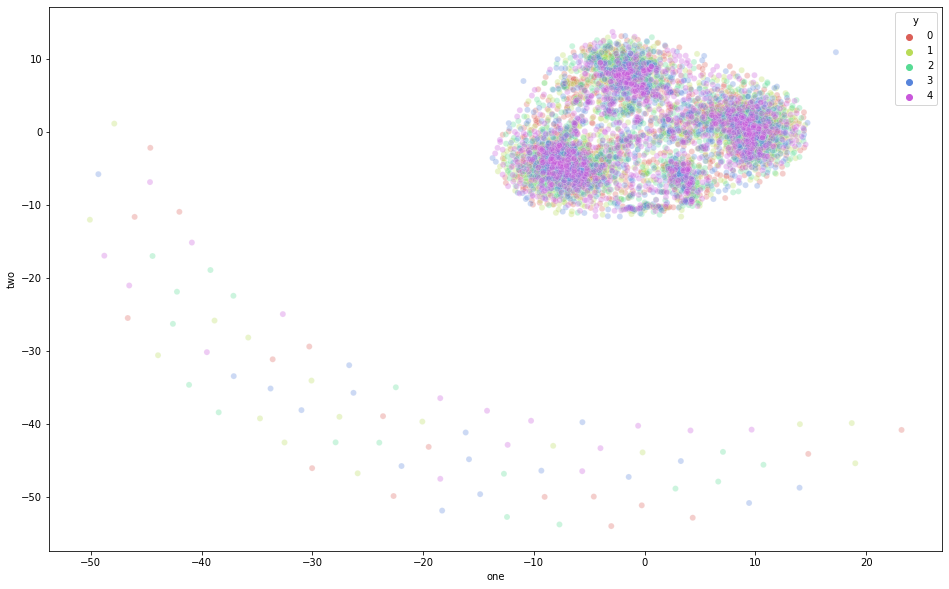

In [64]:
tsne_results = tsne.fit_transform(samples)
# tsne_results = tsne.fit_transform(pca_result)

df = pd.DataFrame()
df['one'] = tsne_results[:, 0]
df['two'] = tsne_results[:, 1]
df['y']   = targets

plt.figure(figsize = (16, 10))
sns.scatterplot(
    x = 'one', y = 'two',
    hue = 'y',
    palette = sns.color_palette('hls', NUM_CLASSES),
    data = df,
    legend = 'full',
    alpha = 0.3
)